In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [4]:
# raw_data = pd.read_csv("data/heart.csv")
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()

raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)
# raw_data.hist(bins=25, figsize=(20,15))

In [5]:
# Categorical Types:
# Binary: sex, exang, fbs
# Multiclass: cp, restecg, thal

original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_data = pd.get_dummies(original_data, 
                               columns=["cp","restecg","thal"],
                               prefix=["cp","restecg","thal"])
original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
0,63,1,145,233,1,150,0,3,0,2.3,1,0,0,0,0,0,1,0,1,0
1,67,1,160,286,0,108,1,2,3,1.5,0,0,0,1,0,0,1,1,0,0
2,67,1,120,229,0,129,1,2,2,2.6,0,0,0,1,0,0,1,0,0,1
3,37,1,130,250,0,187,0,3,0,3.5,0,0,1,0,1,0,0,1,0,0
4,41,0,130,204,0,172,0,1,0,1.4,0,1,0,0,0,0,1,1,0,0


In [6]:
original_data.shape

(297, 20)

In [7]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

#     dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 25, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units = 25, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [8]:
## Need to define a scaling function that ignores categorical values...?

In [9]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                525       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,227
Trainable params: 1,227
Non-trainable params: 0
___________________

Using TensorFlow backend.


In [10]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.431, Acc:0.8837
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.537 accuracy=0.8214
Fold Correct: 23
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.432, Acc:0.8721
Prediction Accuracy
28/28 [==============================] - 0s 15us/step
Scores on data set: loss=0.465 accuracy=0.8571
Fold Correct: 24
Running worker: 2
Fold: 2 -> Loss:0.484, Acc:0.8721
Prediction Accuracy
28/28 [==============================] - 0s 16us/step
Scores on data set: loss=0.678 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.463, Acc:0.8876
Prediction Accuracy
27/27 [==============================] - 0s 13us/step
Scores on data set: loss=0.609 accuracy=0.8148
Fold Correct: 22
Running worker: 4
Fold: 4 -> Loss:0.407, Acc:0.8769
Prediction Accuracy
26/26 [=====

Confusion matrix, without normalization
[[0.88888889 0.11111111]
 [0.19512195 0.80487805]]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a32ff8470>, array([[128,  16],
        [ 24,  99]]))

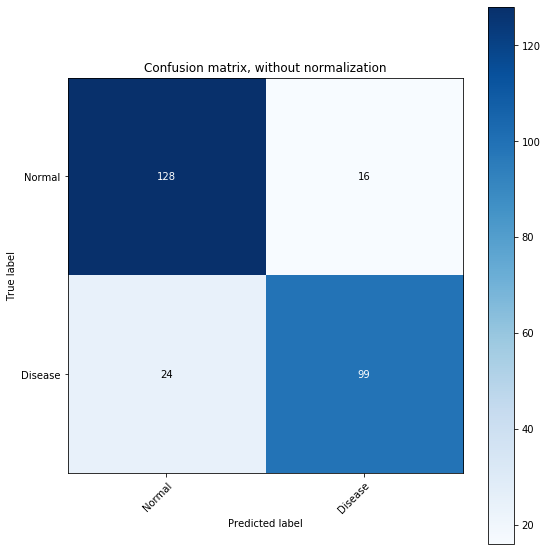

In [11]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [12]:
# min_cluster_sizes=range(3,20,1)
pipeline.train_clusterer(class_label=1, plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:751

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",2,0.0,0.417084,0.417084
"(13, 12)",2,0.0,0.417084,0.417084
"(13, 13)",2,0.0,0.417084,0.417084
"(14, 12)",2,0.0,0.417084,0.417084
"(14, 13)",2,0.0,0.417084,0.417084
"(14, 14)",2,0.0,0.417084,0.417084
"(15, 12)",2,0.0,0.417084,0.417084
"(15, 13)",2,0.0,0.417084,0.417084
"(15, 14)",2,0.0,0.417084,0.417084
"(15, 15)",2,0.0,0.417084,0.417084


In [13]:
pipeline.training_lrp.shape

(99, 20)

In [14]:
pd.Series(pipeline.clusterer.labels_).value_counts()

1    58
0    41
dtype: int64

In [15]:
# Internally populates self.val_set_lrp
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!
Prediction Accuracy: 0.8333


In [16]:
pd.Series(cluster_labels).value_counts()

1    9
0    2
dtype: int64

In [17]:
pipeline.target_class

1

## Plotting Relevance Clusters

In [18]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp
training_lrp.shape

(99, 20)

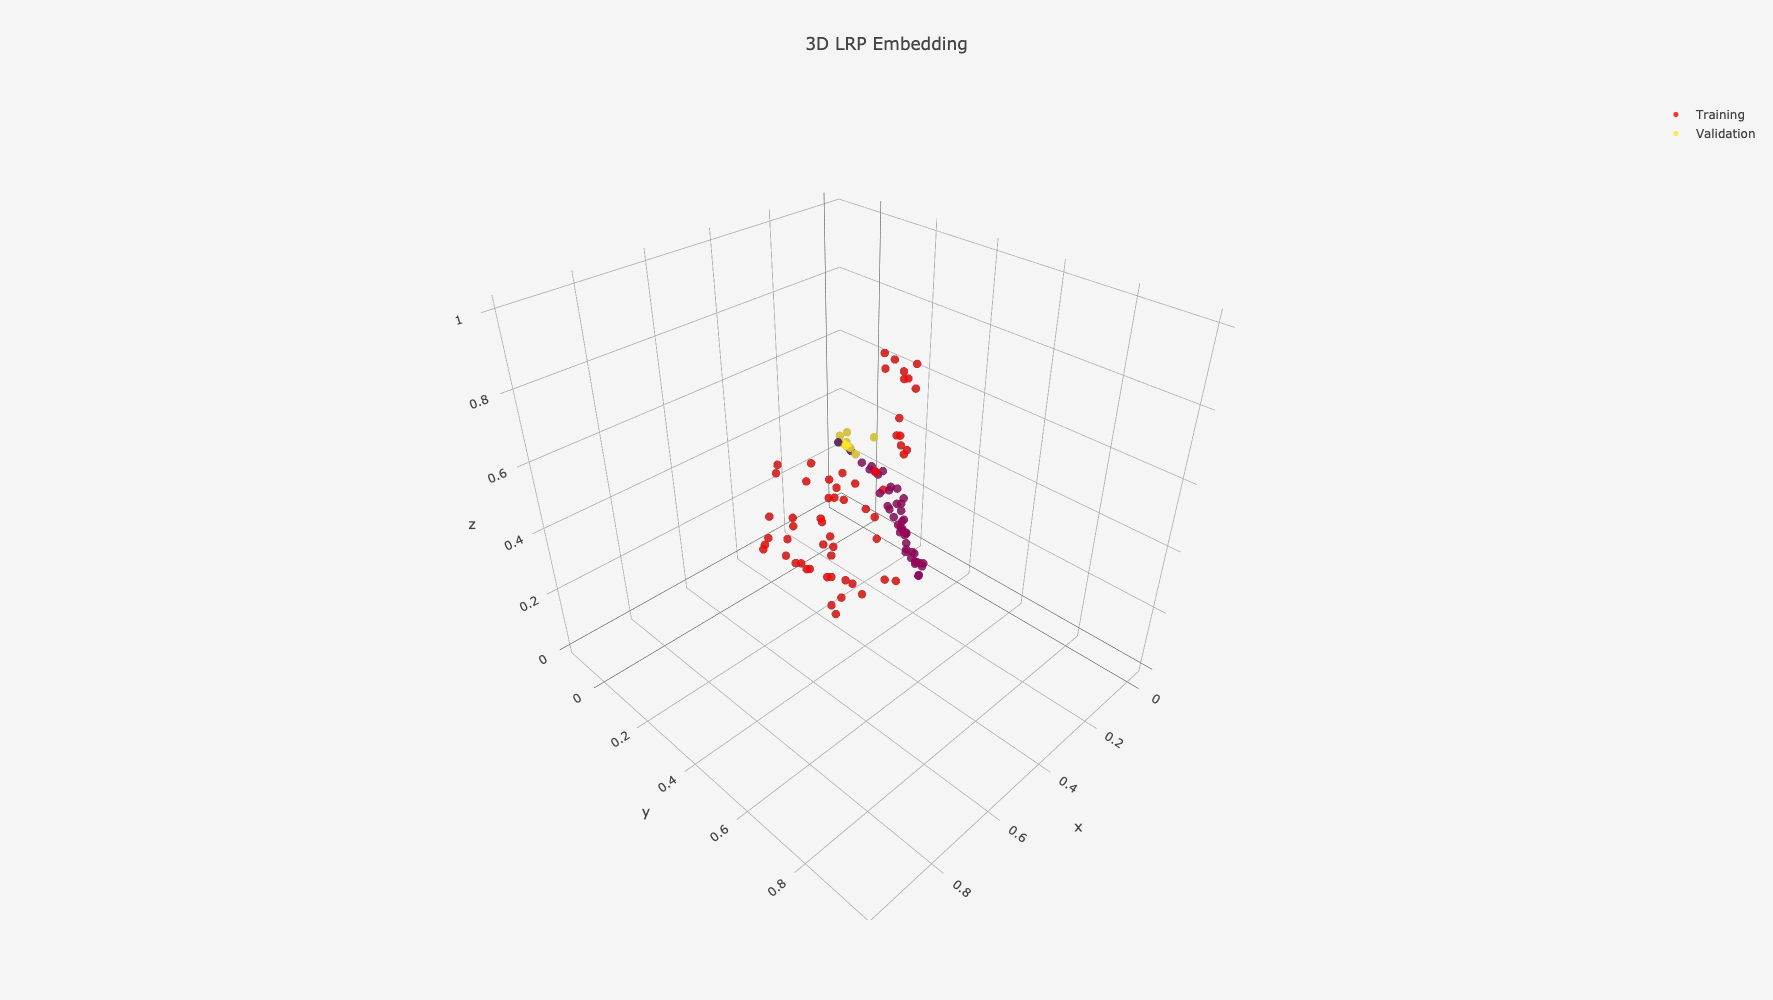

In [19]:
# pipeline.reducer_pipeline[0].n_neighbors
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)

embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5',
#     template="plotly"
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
# fig.update_layout(template="plotly")  /

iplot(fig, filename='lrp-3d-scatter.html')

# Performing Feature Reduction

In [20]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.8) <= thresh)

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

## Getting largest subcluster samples from validation set

In [21]:
max(pipeline.clusterer.labels_)
[x for x in range(0,0)]

[]

In [22]:
subcluster_labels = range(0,max(pipeline.clusterer.labels_)+1)




In [23]:
largest_cluster = pd.Series(cluster_labels).value_counts().idxmax()
largest_cluster

1

In [24]:
cluster_label = largest_cluster
val_clustered = pd.DataFrame(val_lrp[(cluster_labels == cluster_label)], columns = X_train.columns)

In [25]:
val_clustered.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
count,9.0,9.000000,9.000000,9.000000,9.0,9.0,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.0,9.000000,9.0,9.0,9.000000,9.0,9.0,9.000000
mean,0.0,0.098941,23.087097,8.094580,0.0,0.0,0.047874,0.448208,0.600396,0.045969,0.0,0.002596,0.0,0.170434,0.0,0.0,0.000386,0.0,0.0,0.213690
std,0.0,0.012766,2.503797,2.828207,0.0,0.0,0.036043,0.107631,0.467103,0.039730,0.0,0.007788,0.0,0.128116,0.0,0.0,0.001158,0.0,0.0,0.122893
min,0.0,0.077607,19.425772,1.477299,-0.0,0.0,0.000000,0.258363,0.000000,0.000000,-0.0,0.000000,0.0,0.000000,-0.0,0.0,0.000000,-0.0,-0.0,0.000000
25%,0.0,0.092646,20.957033,7.018476,-0.0,0.0,0.000000,0.468149,0.389063,0.017703,-0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,-0.0,-0.0,0.258246
50%,0.0,0.103329,23.649437,9.175856,-0.0,0.0,0.068819,0.491036,0.403892,0.041610,-0.0,0.000000,-0.0,0.246967,-0.0,0.0,0.000000,-0.0,-0.0,0.260428
75%,0.0,0.108687,25.401581,9.872766,-0.0,0.0,0.071398,0.516870,0.930103,0.065565,-0.0,0.000000,-0.0,0.257480,0.0,0.0,0.000000,-0.0,0.0,0.270495
max,0.0,0.111256,25.996376,10.351434,-0.0,0.0,0.078463,0.530876,1.222010,0.107424,-0.0,0.023364,0.0,0.274632,-0.0,0.0,0.003474,-0.0,-0.0,0.321697


In [26]:
# thresh = min(val_clustered.describe().loc["75%"])

In [27]:
reduced_val = get_relevant_cols(val_clustered, thresh=0)
reduced_val.head()

,sex,trestbps,chol,exang,slope,ca,oldpeak,cp_4,thal_7
0,0.108687,25.669594,10.351434,0.000000,0.516870,0.000000,0.017703,0.000000,0.259141
1,0.080863,19.425772,1.477299,0.078463,0.468149,0.918516,0.102148,0.246915,0.000000
2,0.103329,20.423168,7.991067,0.000000,0.502604,0.403892,0.041610,0.246967,0.261571
3,0.110104,20.957033,9.175856,0.000000,0.530876,1.222010,0.065565,0.000000,0.270495
4,0.097560,24.597263,7.018476,0.074591,0.491036,0.930103,0.107424,0.247906,0.291630


In [28]:
val_clustered_2 = pd.DataFrame(val_lrp[(cluster_labels == 0)], columns = X_train.columns)
reduced_val_2 = get_relevant_cols(val_clustered_2, thresh=0)
reduced_val_2.head()

,sex,trestbps,chol,slope,ca,oldpeak,cp_4
0,0.073919,23.090256,0.000000,0.454747,0.000000,0.133304,0.248651
1,0.113136,20.141960,7.679931,0.265457,1.189265,0.023861,0.000000


## Using reduced features for retraining

> **Only values from the same cluster can be retrained**

In [29]:
feature_idxs = reduced_val.columns
feature_idxs

Index(['sex', 'trestbps', 'chol', 'exang', 'slope', 'ca', 'oldpeak', 'cp_4',
       'thal_7'],
      dtype='object')

In [30]:
# ~target_samples

In [31]:
# Ideally only get samples belonging to subclusters

# Separating Control from Target
reindexer = pipeline.testing_idxs
correct_preds = pipeline.correct_preds_bool_arr

target_samples = y_train.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

tsamples = X_train.iloc[reindexer][correct_preds][target_samples]
tlabels = y_train.iloc[reindexer][correct_preds][target_samples]

tsamples = tsamples[(pipeline.clusterer.labels_ == cluster_label)]
tlabels = tlabels[(pipeline.clusterer.labels_ == cluster_label)]


csamples = X_train.iloc[reindexer][correct_preds][control_samples]
csamples = csamples[:len(tsamples)]

clabels = y_train.iloc[reindexer][correct_preds][control_samples]
clabels = clabels[:len(tsamples)]


#Now stack it with control values of same size.. 
X_train_sc = pd.concat([csamples, tsamples], axis="index")
y_train_sc = pd.concat([clabels, tlabels], axis="index")

In [32]:
# All the samples from X_valid are used for now...
X_valid_red = X_valid[feature_idxs]

nn = build_dnn(num_features=X_train_sc.shape[1])
# nn.summary()

### Baseline CN vs Subcluster

> **Reusing the same network architecture may not be valid as the samples are already biased towards it**

In [33]:
baseline_pipeline = ClusterPipeline(nn, [X_train_sc, y_train_sc], [X_valid, y_valid], target_class=1)

baseline_pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.241, Acc:1.0000
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.234 accuracy=1.0000
Fold Correct: 12
Running worker: 1
Fold: 1 -> Loss:0.241, Acc:1.0000
Prediction Accuracy
12/12 [==============================] - 0s 30us/step
Scores on data set: loss=0.240 accuracy=1.0000
Fold Correct: 12
Running worker: 2
Fold: 2 -> Loss:0.247, Acc:0.9904
Prediction Accuracy
12/12 [==============================] - 0s 46us/step
Scores on data set: loss=0.347 accuracy=0.9167
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.260, Acc:0.9904
Prediction Accuracy
12/12 [==============================] - 0s 53us/step
Scores on data set: loss=0.861 accuracy=0.8333
Fold Correct: 10
Running worker: 4
Fold: 4 -> Loss:0.248, Acc:1.0000
Prediction Accuracy
12/12 [==============================] - 0s 47us/step
Scores on data set: loss=0.698 accuracy=0.8333
Fold Correct: 10
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.96551724 0.03448276]
 [0.12068966 0.87931034]]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a46b0c4e0>, array([[56,  2],
        [ 7, 51]]))

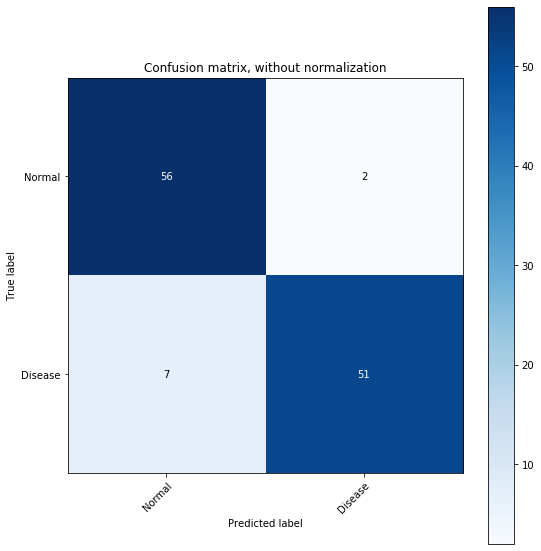

In [34]:
plot_confusion_matrix(y_train_sc.values[baseline_pipeline.testing_idxs], np.array(baseline_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## Original architecture being fed (feature) reduced data

In [35]:
X_train_red = X_train_sc[feature_idxs]
print(X_train_red.shape)
X_train_red.head()

(116, 9)


,sex,trestbps,chol,exang,slope,ca,oldpeak,cp_4,thal_7
184,1,120,240,0,3,0,0.8,0,1
260,1,120,226,0,1,0,0.0,0,0
237,1,110,235,0,1,0,0.0,0,0
50,0,105,198,0,1,1,0.0,0,0
246,1,128,208,0,1,0,0.0,0,0


In [36]:
X_valid_red = X_valid[feature_idxs]

# nn = build_dnn(num_features=X_train_red.shape[1])
# nn.summary()

In [37]:
nn = build_dnn(num_features=X_train_red.shape[1])
optimized_pipeline = ClusterPipeline(nn, [X_train_red, y_train_sc], [X_valid_red, y_valid], target_class=1)

optimized_pipeline.train_model(batch_size=10,epochs=10, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.397, Acc:0.9327
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.532 accuracy=0.9167
Fold Correct: 11
Running worker: 1
Fold: 1 -> Loss:0.376, Acc:0.9519
Prediction Accuracy
12/12 [==============================] - 0s 31us/step
Scores on data set: loss=0.295 accuracy=1.0000
Fold Correct: 12
Running worker: 2
Fold: 2 -> Loss:0.375, Acc:0.9519
Prediction Accuracy
12/12 [==============================] - 0s 30us/step
Scores on data set: loss=0.601 accuracy=0.8333
Fold Correct: 10
Running worker: 3
Fold: 3 -> Loss:0.418, Acc:0.9519
Prediction Accuracy
12/12 [==============================] - 0s 28us/step
Scores on data set: loss=0.711 accuracy=0.7500
Fold Correct: 9
Running worker: 4
Fold: 4 -> Loss:0.420, Acc:0.8942
Prediction Accuracy
12/12 [==============================] - 0s 36us/step
Scores on data set: loss=0.319 accuracy=0.9167
Fold Correct: 11
Running worker: 5
Fol

### Accuracy generally goes down
> **Culprit could be complicated architecture**

Confusion matrix, without normalization
[[0.93103448 0.06896552]
 [0.0862069  0.9137931 ]]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a494a0d30>, array([[54,  4],
        [ 5, 53]]))

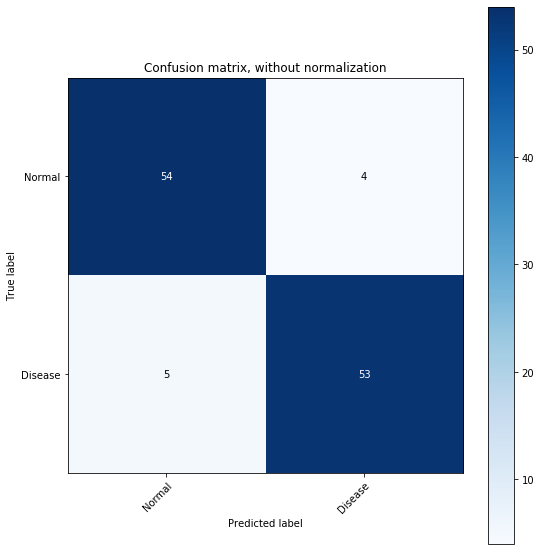

In [38]:
plot_confusion_matrix(y_train_sc.values[optimized_pipeline.testing_idxs], np.array(optimized_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## Rebuilding a (simpler) DNN architecture

In [39]:
def build_shallow_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 15, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 10, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=5, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [40]:
nn = build_shallow_dnn(num_features=X_train_red.shape[1])

shallow_pipeline = ClusterPipeline(nn, [X_train_red, y_train_sc], [X_valid_red, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=10,epochs=20, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.268, Acc:0.9231
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.299 accuracy=0.8333
Fold Correct: 10
Running worker: 1
Fold: 1 -> Loss:0.313, Acc:0.9038
Prediction Accuracy
12/12 [==============================] - 0s 41us/step
Scores on data set: loss=0.154 accuracy=1.0000
Fold Correct: 12
Running worker: 2
Fold: 2 -> Loss:0.232, Acc:0.9519
Prediction Accuracy
12/12 [==============================] - 0s 65us/step
Scores on data set: loss=0.225 accuracy=0.9167
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.285, Acc:0.9038
Prediction Accuracy
12/12 [==============================] - 0s 49us/step
Scores on data set: loss=0.583 accuracy=0.7500
Fold Correct: 9
Running worker: 4
Fold: 4 -> Loss:0.418, Acc:0.8654
Prediction Accuracy
12/12 [==============================] - 0s 49us/step
Scores on data set: loss=0.167 accuracy=1.0000
Fold Correct: 12
Running worker: 5
Fol

- ### Better accuracy than original architecure being fed reduced features
- ### Generally beats original non-subclustered analysis
- ### Not as good as orginal with subclustered data
    - **Thats expected however due to the implicit bias in the subclusters**


Confusion matrix, without normalization
[[0.89655172 0.10344828]
 [0.05172414 0.94827586]]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a4baf0828>, array([[52,  6],
        [ 3, 55]]))

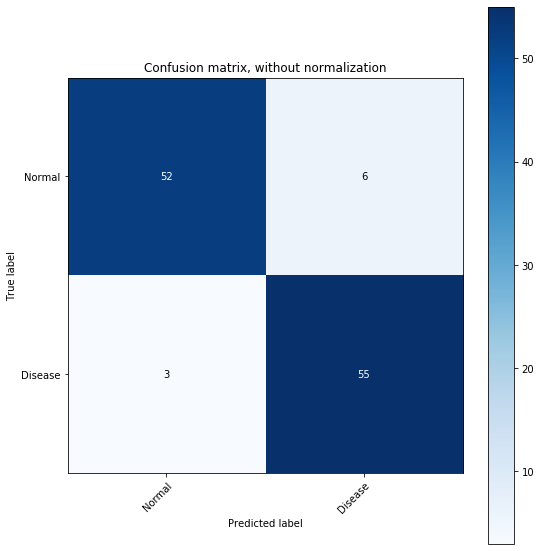

In [41]:
plot_confusion_matrix(y_train_sc.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## NN w/ ALL features
- ### Performs just as well as original architecure with subcluster

In [42]:
nn = build_shallow_dnn(num_features=X_train_sc.shape[1])
shallow_pipeline = ClusterPipeline(nn, [X_train_sc, y_train_sc], [X_valid, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=10,epochs=20, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.182, Acc:0.9615
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.275 accuracy=0.8333
Fold Correct: 10
Running worker: 1
Fold: 1 -> Loss:0.294, Acc:0.9231
Prediction Accuracy
12/12 [==============================] - 0s 30us/step
Scores on data set: loss=0.114 accuracy=1.0000
Fold Correct: 12
Running worker: 2
Fold: 2 -> Loss:0.269, Acc:0.9423
Prediction Accuracy
12/12 [==============================] - 0s 44us/step
Scores on data set: loss=0.420 accuracy=0.8333
Fold Correct: 10
Running worker: 3
Fold: 3 -> Loss:0.191, Acc:0.9615
Prediction Accuracy
12/12 [==============================] - 0s 37us/step
Scores on data set: loss=0.533 accuracy=0.8333
Fold Correct: 10
Running worker: 4
Fold: 4 -> Loss:0.191, Acc:0.9615
Prediction Accuracy
12/12 [==============================] - 0s 33us/step
Scores on data set: loss=0.217 accuracy=0.9167
Fold Correct: 11
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.93103448 0.06896552]
 [0.10344828 0.89655172]]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a4a95bf60>, array([[54,  4],
        [ 6, 52]]))

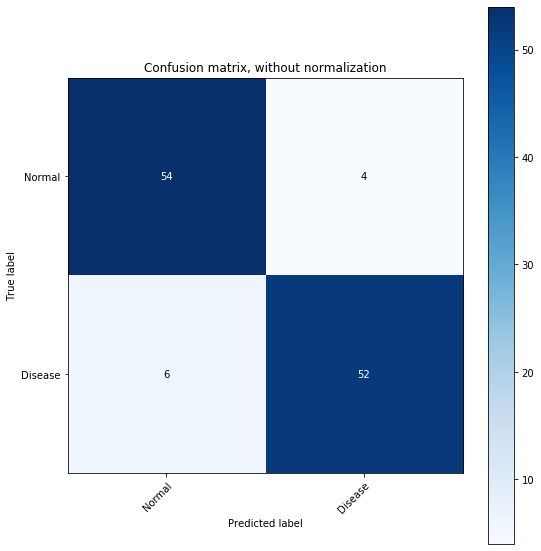

In [43]:
plot_confusion_matrix(y_train_sc.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## NN w/ original data

In [44]:
nn = build_shallow_dnn(num_features=X_train.shape[1])

shallow_pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=10,epochs=30, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.483, Acc:0.8488
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.433 accuracy=0.8571
Fold Correct: 24
Running worker: 1
Fold: 1 -> Loss:0.489, Acc:0.8411
Prediction Accuracy
28/28 [==============================] - 0s 12us/step
Scores on data set: loss=0.413 accuracy=0.8571
Fold Correct: 24
Running worker: 2
Fold: 2 -> Loss:0.445, Acc:0.8333
Prediction Accuracy
28/28 [==============================] - 0s 12us/step
Scores on data set: loss=0.602 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.443, Acc:0.8682
Prediction Accuracy
27/27 [==============================] - 0s 19us/step
Scores on data set: loss=0.506 accuracy=0.8519
Fold Correct: 23
Running worker: 4
Fold: 4 -> Loss:0.430, Acc:0.8615
Prediction Accuracy
26/26 [==============================] - 0s 16us/step
Scores on data set: loss=0.964 accuracy=0.6154
Fold Correct: 16
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.79032258 0.20967742]
 [0.10135135 0.89864865]]


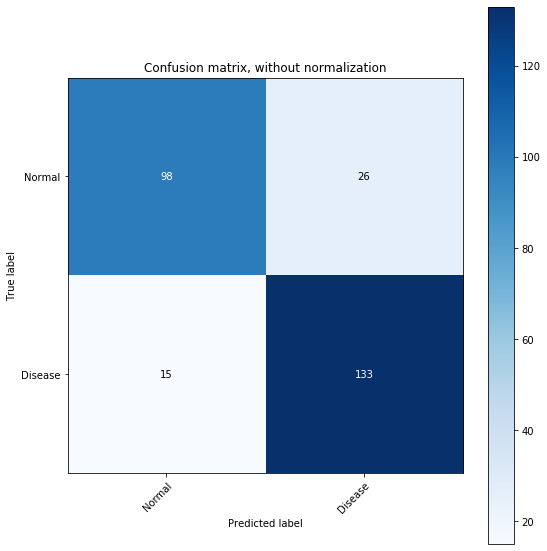

In [51]:
plot_confusion_matrix(y_train.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

# SVM Analysis

In [38]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()


clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC())
])

def runSVM(X,y, X_valid,y_valid):
    
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf

## SVM trained on original data

In [39]:
original_svm = runSVM(X_train, y_train, X_valid, y_valid)

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.742
SVM CV Accuracy: 0.861(+/- 0.105)


## Trained on subcluster vs control only

In [40]:
%time cluster_svm = runSVM(X_train_sc, y_train_sc, X_valid, y_valid)

{'C': 10, 'dual': False, 'max_iter': 10000000, 'penalty': 'l2', 'tol': 0.0001}
SVM Test Accuracy: 0.710
SVM CV Accuracy: 0.981(+/- 0.080)
CPU times: user 182 ms, sys: 4.72 ms, total: 187 ms
Wall time: 357 ms


## Trained on feature reduced subcluster
> ### Despite losing almost half the features, we still retain a high accuracy
> ### This may be an indication that the subclustering was infact a valid one

In [41]:
%time cluster_svm = runSVM(X_train_red, y_train_sc, X_valid_red, y_valid)

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.613
SVM CV Accuracy: 0.895(+/- 0.124)
CPU times: user 180 ms, sys: 4.7 ms, total: 185 ms
Wall time: 2.74 s
